# Description

This script creates a data pattern designed for use in a machine learning algorithm. The goal is for the algorithm to predict the morph level of stimuli based on brain signals obtained from fMRI data. The process involves running a General Linear Model (GLM) where each trial is represented by its own regressor. Due to computational limitations, the GLMs are run on selected Regions of Interest (ROIs) based on regions used in a prior study, excluding the Temporoparietal Junction (TPJ) as it is not defined in the Harvard-Oxford Atlas, though it can be added later using another atlas. The analysis is conducted on a part of the available dataset. A contrast is calculated between each regressor and the baseline, and the resulting beta values are used as input data in the pattern provided to the machine learning model.

Two options are available: one where the machine learning model runs on data from all Regions of Interest (ROIs) combined, and another where the model is run separately on data from each ROI.

In [6]:
import pandas as pd
import os
from scipy.io import loadmat
from nilearn import image, plotting, datasets, masking
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
import json
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

# Load packages and define main path

In [7]:
# PATH # 
workflow_name = 'spm_preproc1'
base_path = f"/home/td/fMRI_internship/derivatives/datasink/{workflow_name}" #path where preprocessed images can be found

# SUBJECT AND TASK #
subject_list = ['sub-01', 'sub-06']
task_list = ['task-emodet']

sub = subject_list[0] # choose subj and task for analysis
task = task_list[0]

# LOAD IMAGE #
func = image.load_img(f"{base_path}/{sub}/{task}/fwhm-4swra{sub}_{task}_bold_roi.nii")

# LOAD ONSETS #
onsets_file_path = os.path.join('/home/td/fMRI_internship/raw/', sub, 'func', f'{sub}_{task}_onsets.mat')
onsets_data = loadmat(onsets_file_path)

# LOAD JSON #
json_path = f'/home/td/fMRI_internship/raw/{sub}/func/{sub}_{task}_bold.json'
with open(json_path, 'r') as file:
    content = file.read()
    json_data = json.loads(content)
    
t_r = json_data['RepetitionTime']
n_vols = func.shape[-1]
frame_times = np.linspace(t_r / 2, n_vols * t_r + t_r / 2, n_vols, endpoint=False)
slice_time_ref = 0.25

### load realignment parameter to use as confounds ###
realignment_params_path = os.path.join(base_path, sub, task, f'rp_a{sub}_{task}_bold_roi.txt')
realignment_params = np.loadtxt(realignment_params_path)
realignment_params_df = pd.DataFrame(data=realignment_params, columns=["x", "y", "z", "pitch", "roll", "yaw"])
# columns 1-3 represent x, y and z translations in mm, while columns 4-6 correspond to pitch, roll and yaw rotations in radians.

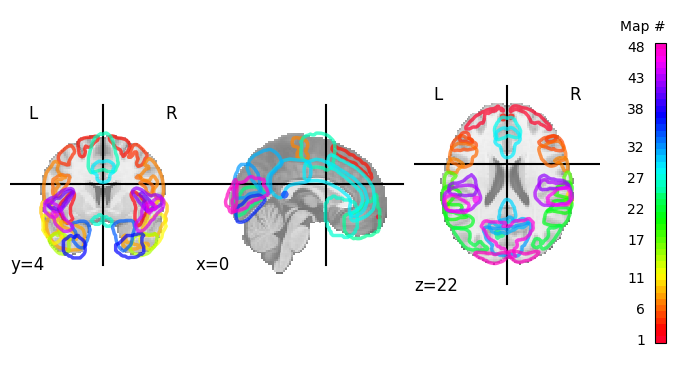

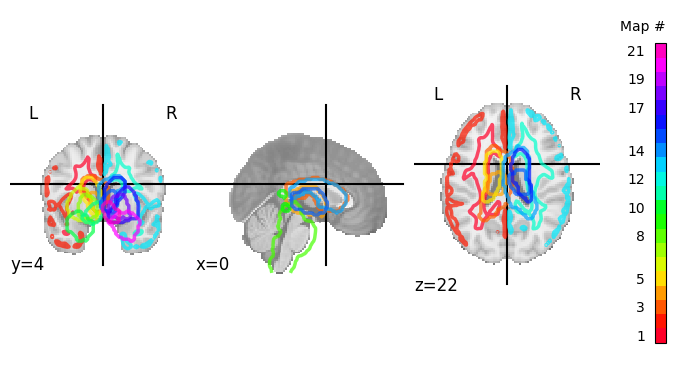

In [8]:
# LOAD ATLAS:  Harvard-Oxford atlas - PROBABILITY 
"""
There are two primary types of atlas images in FSL:

A probabilistic atlas is a 4D NIFTI image, where each 3D volume contains a probability map for one region in the atlas. 
Each 3D volum contains values between 0 and 100, indicating the probability that a given voxel is classified as belonging
to the structure represented by that volume. A label (or summary, or hard segementation) atlas is a 3D NIfTI image which 
contains different discrete integer values for each region defined in the atlas.
"""
ho_cort_prob_atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
ho_cort_prob_atlas_img = image.load_img(ho_cort_prob_atlas['maps'])
display = plotting.plot_prob_atlas(ho_cort_prob_atlas_img, colorbar=True)#, threshold="90%")

ho_sub_prob_atlas = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
ho_sub_prob_atlas_img = image.load_img(ho_sub_prob_atlas['maps'])
display = plotting.plot_prob_atlas(ho_sub_prob_atlas_img, colorbar=True)#, threshold="90%")


rois_cort_list = ["Inferior Frontal Gyrus, pars triangularis", # anterior
             "Inferior Frontal Gyrus, pars opercularis", # posterior 
             "Insular Cortex",
             "Cingulate Gyrus, anterior division",
             "Cingulate Gyrus, posterior division",
             "Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)",
                "Frontal Medial Cortex"
            ]

rois_sub_list = ['Right Amygdala', 'Left Amygdala']

# Option 1: Run for all ROIs

### Data for the pattern - GLM

In [10]:
# create events with trial types and their onsets 
onset=[]
trial_type_ori=[]

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)

    trial_type_ori.extend([name]*len(current_onset))

events_df = pd.DataFrame(onset, columns=["onset"])
events_df.loc[:, "duration"]=1
events_df.loc[:, 'trial_type'] = ['trial_' + str(i).zfill(3) for i in range(1, len(events_df['onset'])+1)]
events_df.loc[:, 'trial_type_ori'] = trial_type_ori

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)

Creating mask for Inferior Frontal Gyrus, pars triangularis
Creating mask for Inferior Frontal Gyrus, pars opercularis
Creating mask for Insular Cortex
Creating mask for Cingulate Gyrus, anterior division
Creating mask for Cingulate Gyrus, posterior division
Creating mask for Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Creating mask for Frontal Medial Cortex
Creating mask for Right Amygdala
Creating mask for Left Amygdala


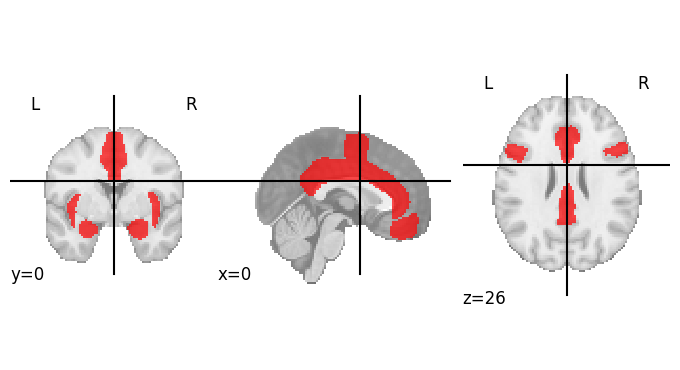

In [11]:
# create mask 

show_each_mask = False # show each mask while creating for sanity check
all_roi_masks = image.new_img_like(image.index_img(func, 0), data = np.zeros(shape=func.shape[:3]))

for rois_list, atlas in zip([rois_cort_list, rois_sub_list], [ho_cort_prob_atlas, ho_sub_prob_atlas]):

    for roi in rois_list:
        
        print(f'Creating mask for {roi}')
                
        #load mask:
        roi_mask = image.index_img(atlas['maps'], atlas['labels'].index(roi)-1) # background in label list but has no mask
        
        #threshold mask:
        roi_mask_thres = image.threshold_img(roi_mask, 25) #25% probability 
        
        #resample to correct for flipping and align the two voxel grids - world coordinates (last col on the right) do not match 
        #to see that call func.affine and roi_mask.affine
        roi_mask_resamp = image.resample_img(roi_mask_thres, 
                                             target_affine=func.affine, 
                                             target_shape=func.shape[:3],
                                             interpolation="nearest")

        if show_each_mask:
            display = plotting.plot_roi(roi_mask_resamp, cmap="autumn", vmin=0, title=roi)
            
        all_roi_masks = image.math_img("np.logical_or(mask1, mask2)", mask1=all_roi_masks, mask2=roi_mask_resamp)
        
plotting.plot_roi(all_roi_masks, cmap="autumn")

<Axes: label='conditions', ylabel='scan number'>

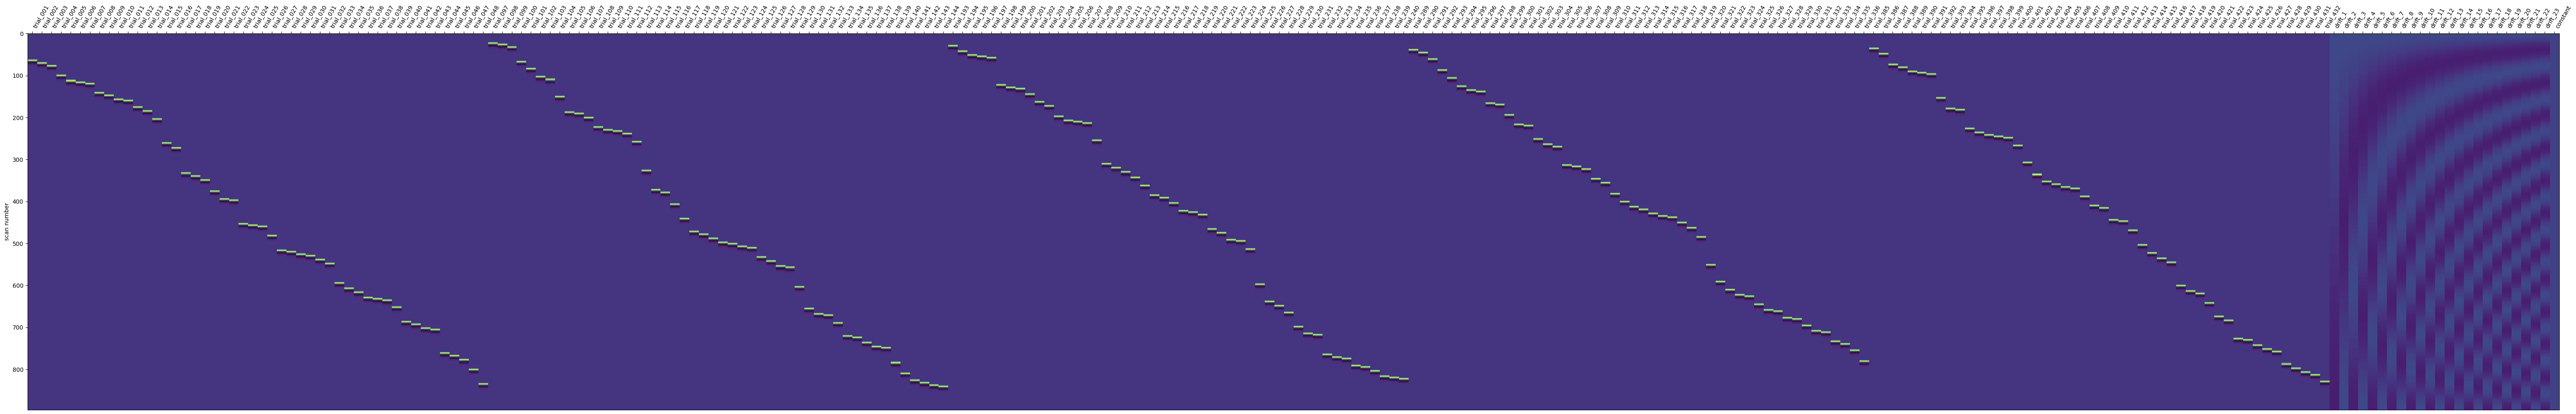

In [13]:
# TEST design matrix (can be skipped because FirstLevelModel can create design matrix internally)
cut=240 # half of the trials (480 in total)
dm = make_first_level_design_matrix(frame_times=frame_times[:int(len(frame_times)/2)],
                                   events=events_df.iloc[:cut, :-1], 
                                   hrf_model="glover",
                                   drift_model="cosine")
#                                    add_regs = realignment_params,
#                                    add_reg_names = list(realignment_params_df.columns)
plotting.plot_design_matrix(dm)

In [14]:
# first level model
flm = FirstLevelModel(t_r=t_r,
                      slice_time_ref=slice_time_ref, 
                      mask_img=all_roi_masks,
                      hrf_model="glover",
                      noise_model="ols",
                      drift_model="cosine", 
                      high_pass=0.01)

cut = 240
cut_func = round(func.shape[-1]/2)
    
flm.fit(run_imgs=image.index_img(func, np.arange(0, cut_func)),
        events=events_df.iloc[:cut, :-1], 
        confounds=realignment_params_df.iloc[:cut_func, :])

FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f47ddbc2f10>,
                noise_model='ols', slice_time_ref=0.25, t_r=1.296)

In [ ]:
# check design matrix 
flm_dm = flm.design_matrices_[0]
plotting.plot_design_matrix(flm_dm.iloc[:, :200])

In [ ]:
# check trial correlation
plt.imshow(dm.iloc[:, :240].corr())

### Pattern - Put together 

In [ ]:
# pattern created by taking z-score
pattern = []
for trial in flm_dm.columns[:cut]:
    contrast = flm.compute_contrast(trial, stat_type="t", output_type="z_score")
    masked = masking.apply_mask(contrast, all_roi_masks)
    pattern.append(masked)   

pattern_arr = np.vstack(pattern)

# uncorrelate trials 
X = flm_dm.values[:, :cut]
pattern_unc = sqrtm(X.T @ X) @ pattern_arr

In [ ]:
# pattern takes up much memory, better to save them, restart the kernel, load them and run further analysis 
np.save(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/pattern_z_score.npy", pattern_arr)
np.save(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/pattern_z_score_uncorr.npy", pattern_unc)

In [ ]:
# pattern created by taking effect size
pattern = []
for trial in flm_dm.columns[:cut]:
    contrast = flm.compute_contrast(trial, stat_type="t", output_type="effect_size")
    masked = masking.apply_mask(contrast, all_roi_masks)
    pattern.append(masked)   

pattern_arr = np.vstack(pattern)

# uncorrelate trials 
X = flm_dm.values[:, :cut]
pattern_unc = sqrtm(X.T @ X) @ pattern_arr

In [ ]:
# pattern takes up much memory, better to save them, restart the kernel, load them and run further analysis 
np.save(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/pattern_effect_size.npy", pattern_arr)
np.save(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/pattern_effect_size_uncorr.npy", pattern_unc)

### Load pattern

In [21]:
# choose the pattern you want to use and load them
R = np.load(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/pattern_effect_size.npy")
# R_unc = np.load(f"/home/td/fMRI_internship/derivatives-ni-edu-benv/{sub}/{task}/pattern_effect_size_uncorr.npy")

In [23]:
R.shape

(240, 14806)

In [ ]:
# # Check after uncorrelation - see if the machine learning you use prefere uncorrelated data or not
# # If not, you can skip this
# # The pattern is large so consider plotting part of them for checking 

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))  

# mapp1 = ax1.imshow(np.corrcoef(R[:50, :]), vmin=-1, vmax=1)
# cbar1 = fig.colorbar(mapp1, ax=ax1, shrink=0.1)  
# ax1.set_title(r"$\mathbf{R}$", fontsize=20)

# mapp2 = ax2.imshow(np.corrcoef(R_unc[:50, :]), vmin=-1, vmax=1)
# cbar2 = fig.colorbar(mapp2, ax=ax2, shrink=0.1) 
# ax2.set_title(r"$\mathbf{R}_{unn}$", fontsize=20)

# # Adjust layout to avoid overlap
# plt.tight_layout()
# plt.show()

# print(np.mean(np.corrcoef(R)))
# print(np.mean(np.corrcoef(R_unc)))

### Classification

In [24]:
# create event_df to determine the trial types and their onsets. 
cut = 240
onset=[]
trial_type_ori=[]

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)

    trial_type_ori.extend([name]*len(current_onset))

events_df = pd.DataFrame(onset, columns=["onset"])
events_df.loc[:, 'trial_type_ori'] = trial_type_ori

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)
events_df = events_df[:cut]

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression # classification model 
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold # each fold contains the same proportion of the different classes 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# create labels - give the morph level a number value 
lab_enc = LabelEncoder()
S_num = lab_enc.fit_transform(events_df['trial_type_ori'].values)
print(lab_enc.classes_)

# divide data for cross validation
skf = RepeatedStratifiedKFold(n_splits=6, random_state=15, n_repeats=20)#, shuffle=True)
folds = skf.split(R, S_num)

# make pipeline 
pca = PCA (n_components=45) #feature extraction
# scaler = RobustScaler() #standardize the pattern 
scaler = StandardScaler()
# clf = LogisticRegression(solver="lbfgs", max_iter=2000) # solver: algorithm to use in the optimization problem. # model
clf = RandomForestClassifier()

pipe = make_pipeline(scaler, pca, clf)

# training 
acc = []
for fold in folds:
    train_idx, test_idx = fold
    
    S_train_fold = S_num[train_idx]
    S_test_fold = S_num[test_idx]
    
    R_train_fold = R[train_idx, :]
    R_test_fold = R[test_idx, :]
    
    # training and prediction 
    pipe.fit(R_train_fold, S_train_fold)
    preds = pipe.predict(R_test_fold)
    
    # accuracy calculation 
    acc.append(accuracy_score(S_test_fold, preds))
    
mean_acc = np.mean(acc)

['morph_0_100' 'morph_20_80' 'morph_40_60' 'morph_45_55' 'morph_50_50']


In [7]:
mean_acc

0.208125

In [8]:
# TEST number of compoenent that should be given to PCA - criteria: explained variance is high. 
pca = PCA(n_components=45)  # Experiment with higher components
pca.fit(R)

explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
print(explained_variance_ratio)

# Print cumulative explained variance (to see how much variance is captured by increasing components)
cumulative_variance = np.cumsum(explained_variance_ratio)
print(cumulative_variance)

[0.17488828 0.15478687 0.11829079 0.07546514 0.05621235 0.05508483
 0.04576168 0.0359846  0.03510475 0.03163099 0.02916394 0.02422503
 0.02301567 0.02138417 0.0199763  0.01738571 0.01378023 0.0081169
 0.00609168 0.00451614 0.00375474 0.00317895 0.00264648 0.00210507
 0.00194462 0.00175746 0.00123624 0.00119222 0.00115763 0.00106859
 0.00090867 0.0007926  0.00076992 0.00075483 0.00070723 0.00068641
 0.00061114 0.00059207 0.00056831 0.00055592 0.00052298 0.00050068
 0.0004918  0.00046079 0.00045716]
[0.17488828 0.32967515 0.44796594 0.52343107 0.57964342 0.63472826
 0.68048994 0.71647454 0.75157929 0.78321029 0.81237422 0.83659926
 0.85961493 0.8809991  0.9009754  0.91836112 0.93214135 0.94025825
 0.94634993 0.95086607 0.95462081 0.95779976 0.96044624 0.96255131
 0.96449593 0.96625339 0.96748962 0.96868184 0.96983947 0.97090806
 0.97181673 0.97260933 0.97337925 0.97413409 0.97484132 0.97552773
 0.97613887 0.97673094 0.97729925 0.97785516 0.97837814 0.97887883
 0.97937063 0.97983142 0.980

# Option 2: Run for each ROI

In [9]:
# Process is the same as in Option 1. Functions are created to repeat the process easily
# FUNCTIONS: 
def create_mask(roi_name, atlas, func_img, show_mask = False):
    
    print(f'Creating mask for {roi_name}')
    
    #load mask:
    roi_mask = image.index_img(atlas['maps'], atlas['labels'].index(roi_name)-1) # background in label list but has no mask

    #threshold mask:
    roi_mask_thres = image.threshold_img(roi_mask, 25) #25% probability 

    #resample to correct for flipping and align the two voxel grids - world coordinates (last col on the right) do not match 
    #to see that call func.affine and roi_mask.affine
    roi_mask_resamp = image.resample_img(roi_mask_thres, 
                                         target_affine=func_img.affine, 
                                         target_shape=func_img.shape[:3],
                                         interpolation="nearest")
    
    roi_mask_binary = image.math_img("img>0", img=roi_mask_resamp)

    if show_mask:
        display = plotting.plot_roi(roi_mask_binary, cmap="autumn", vmin=0, title=roi_name)
        
    return roi_name, roi_mask_binary


def create_betas_pattern(sub, task, func_img, t_r, slice_time_ref, mask_img_name, mask_img, events, realignment_params, #for running glm
                         cut_factor=2, hrf_model="glover", noise_model="ols", drift_model="cosine", high_pass=0.01, #for running glm
                         stat_type="t", output_type_list=["z_score", "effect_size"], # for computing contrast
                         output_home_dir="/home/td/fMRI_internship/derivatives-ni-edu-env"):
    
    # first level model
    flm = FirstLevelModel(t_r=t_r, slice_time_ref=slice_time_ref, 
                          mask_img=mask_img, hrf_model=hrf_model,
                          noise_model=noise_model, drift_model=drift_model, high_pass=high_pass)

    cut_func = round(func_img.shape[-1]/cut_factor)
    cut_event = int(len(events)/cut_factor)

    flm.fit(run_imgs=image.index_img(func_img, np.arange(0, cut_func)),
            events=events.iloc[:cut_event, :-1], 
            confounds=realignment_params.iloc[:cut_func, :])
    
    # create pattern 
    flm_dm = flm.design_matrices_[0]
    
    print(f'Creating pattern for {mask_img_name}')
    for output_type in output_type_list:
        pattern = []
        for trial in flm_dm.columns[:cut_event]:
            contrast = flm.compute_contrast(trial, stat_type=stat_type, output_type=output_type) # each trial aginst baseline 
            masked = masking.apply_mask(contrast, mask_img)
            pattern.append(masked)

        pattern_arr = np.vstack(pattern)

        # uncorrelate trials 
        X = flm_dm.values[:, :cut_event]
        pattern_unc = sqrtm(X.T @ X) @ pattern_arr

        np.save(f"{output_home_dir}/{sub}/{task}/{mask_img_name}_pattern_{output_type}.npy", pattern_arr)
        np.save(f"{output_home_dir}/{sub}/{task}/{mask_img_name}_pattern_{output_type}_uncorr.npy", pattern_unc)

### Data for the pattern - GLM

In [10]:
# create events with trial types and their onsets 
onset=[]
trial_type_ori=[]

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)

    trial_type_ori.extend([name]*len(current_onset))

events_df = pd.DataFrame(onset, columns=["onset"])
events_df.loc[:, "duration"]=1
events_df.loc[:, 'trial_type'] = ['trial_' + str(i).zfill(3) for i in range(1, len(events_df['onset'])+1)]
events_df.loc[:, 'trial_type_ori'] = trial_type_ori

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)

In [ ]:
# mask and create pattern for sub cortial area
for roi_name in rois_sub_list:
    
    mask_img_name, mask_img = create_mask(roi_name, atlas=ho_sub_prob_atlas, func_img=func, show_mask = True)
    create_betas_pattern(sub, task, func_img=func, t_r=t_r, slice_time_ref=slice_time_ref,
                         mask_img_name=mask_img_name, mask_img=mask_img, events=events_df,
                         realignment_params=realignment_params_df, cut_factor=2,
                         hrf_model="glover", noise_model="ols", drift_model="cosine", high_pass=0.01,
                         stat_type="t", output_type_list=["z_score", "effect_size"],
                         output_home_dir="/home/td/fMRI_internship/derivatives-ni-edu-env")

Creating mask for Inferior Frontal Gyrus, pars triangularis
Creating pattern for Inferior Frontal Gyrus, pars triangularis
Creating mask for Inferior Frontal Gyrus, pars opercularis
Creating pattern for Inferior Frontal Gyrus, pars opercularis
Creating mask for Insular Cortex
Creating pattern for Insular Cortex
Creating mask for Cingulate Gyrus, anterior division
Creating pattern for Cingulate Gyrus, anterior division
Creating mask for Cingulate Gyrus, posterior division
Creating pattern for Cingulate Gyrus, posterior division
Creating mask for Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Creating pattern for Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Creating mask for Frontal Medial Cortex
Creating pattern for Frontal Medial Cortex


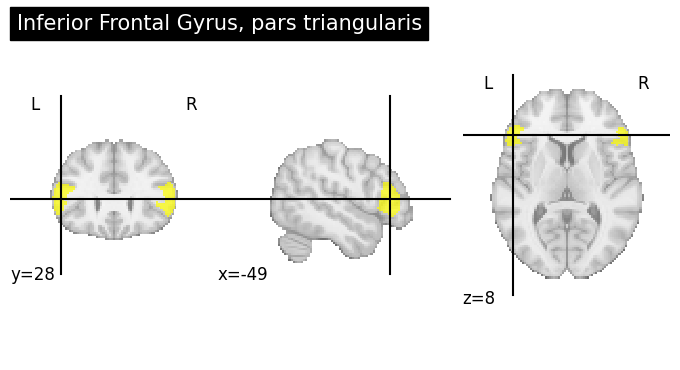

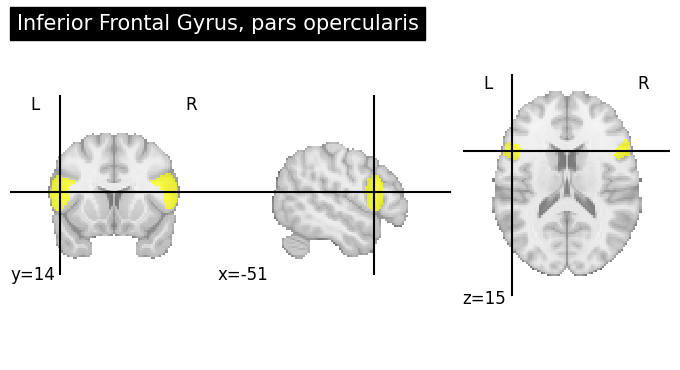

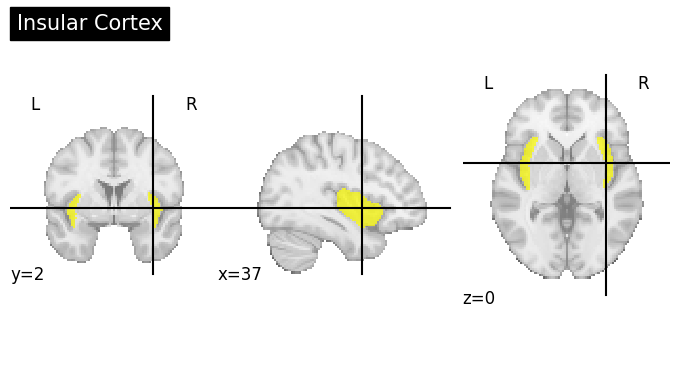

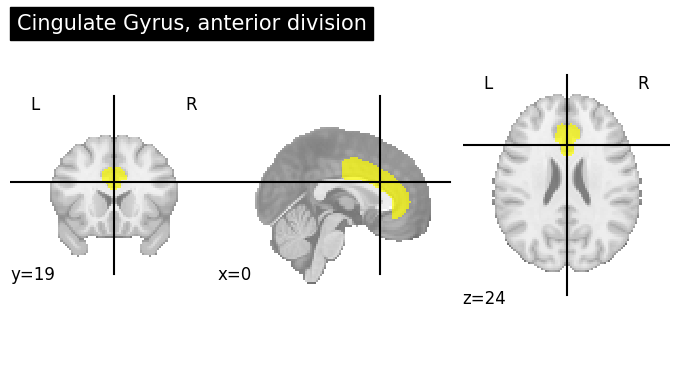

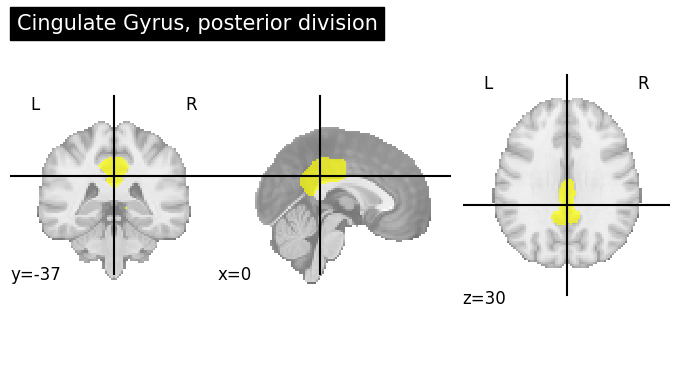

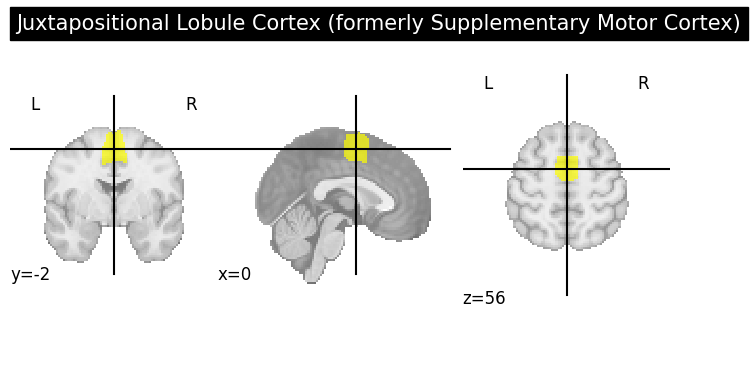

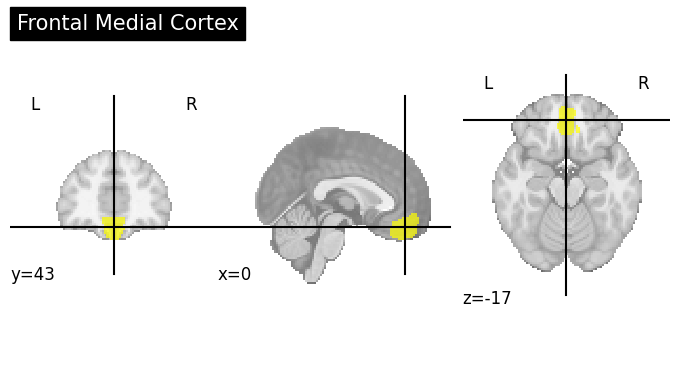

In [32]:
# mask and create pattern for cortial area
for roi_name in rois_cort_list:
    
    mask_img_name, mask_img = create_mask(roi_name, atlas=ho_cort_prob_atlas, func_img=func, show_mask = True)
    create_betas_pattern(sub, task, func_img=func, t_r=t_r, slice_time_ref=slice_time_ref,
                         mask_img_name=mask_img_name, mask_img=mask_img, events=events_df,
                         realignment_params=realignment_params_df, cut_factor=2,
                         hrf_model="glover", noise_model="ols", drift_model="cosine", high_pass=0.01,
                         stat_type="t", output_type_list=["z_score", "effect_size"],
                         output_home_dir="/home/td/fMRI_internship/derivatives-ni-edu-env")

### Classification

In [11]:
# label / experimental feature 
cut = 240
onset=[]
trial_type_ori=[]

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)

    trial_type_ori.extend([name]*len(current_onset))

events_df = pd.DataFrame(onset, columns=["onset"])
events_df.loc[:, 'trial_type_ori'] = trial_type_ori

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)
events_df = events_df[:cut]

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression # classification model 
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold # each fold contains the same proportion of the different classes 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

acc_all_rois = {}
output_type = "effect_size"

for roi_name in rois_cort_list+rois_sub_list:
    
    print(f'Processing {roi_name}')
    
    # load pattern: 
    R = np.load(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/{roi_name}_pattern_{output_type}.npy")
    R_unc = np.load(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/{roi_name}_pattern_{output_type}_uncorr.npy")
    
    # create labels:
    lab_enc = LabelEncoder()
    S_num = lab_enc.fit_transform(events_df['trial_type_ori'].values)
    print(lab_enc.classes_)

    # divide data for cross validation
    skf = RepeatedStratifiedKFold(n_splits=6, random_state=15, n_repeats=20)#, shuffle=True)
    folds = skf.split(R, S_num)

    # make pipeline 
    pca = PCA (n_components=50) #feature extraction
    # scaler = RobustScaler() #standardize the pattern 
    scaler = StandardScaler()
    # clf = LogisticRegression(solver="lbfgs", max_iter=2000) # solver: algorithm to use in the optimization problem. # model
    clf = RandomForestClassifier()

    pipe = make_pipeline(scaler, pca, clf)

    # training 
    acc = []
    for fold in folds:
        train_idx, test_idx = fold

        S_train_fold = S_num[train_idx]
        S_test_fold = S_num[test_idx]

        R_train_fold = R[train_idx, :]
        R_test_fold = R[test_idx, :]
        
        #training and predict
        pipe.fit(R_train_fold, S_train_fold)
        explained_variance_ratio = pca.explained_variance_ratio_
        sum_variance_pca = np.sum(explained_variance_ratio)
        
        if sum_variance_pca < 0.95:
            print(f"Variance explained by pca component is low: {sum_variance_pca}")
        
        preds = pipe.predict(R_test_fold)

        acc.append(accuracy_score(S_test_fold, preds))
        
    print(f'Accuracy for {roi_name}: {np.mean(acc)}')
    acc_all_rois[roi_name] = acc

Processing Inferior Frontal Gyrus, pars triangularis
Accuracy for Inferior Frontal Gyrus, pars triangularis: 0.19499999999999998
Processing Inferior Frontal Gyrus, pars opercularis
Accuracy for Inferior Frontal Gyrus, pars opercularis: 0.21312500000000004
Processing Insular Cortex
Accuracy for Insular Cortex: 0.20604166666666668
Processing Cingulate Gyrus, anterior division
Accuracy for Cingulate Gyrus, anterior division: 0.1991666666666667
Processing Cingulate Gyrus, posterior division
Accuracy for Cingulate Gyrus, posterior division: 0.21541666666666667
Processing Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Accuracy for Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex): 0.1991666666666667
Processing Frontal Medial Cortex
Accuracy for Frontal Medial Cortex: 0.22729166666666664
Processing Right Amygdala
Accuracy for Right Amygdala: 0.19645833333333332
Processing Left Amygdala
Accuracy for Left Amygdala: 0.21145833333333333
